In [1]:
!pip install -e C:\Users\asus_strix_scar\Anaconda3\Lib\site-packages\gym\envs\steering-optimizer\steering_optimizer\envs\github\steering-optimizer\

Obtaining file:///C:/Users/asus_strix_scar/Anaconda3/Lib/site-packages/gym/envs/steering-optimizer/steering_optimizer/envs/github/steering-optimizer
  Found existing installation: steering-optimizer 0.0.1
    Uninstalling steering-optimizer-0.0.1:
      Successfully uninstalled steering-optimizer-0.0.1
  Running setup.py develop for steering-optimizer


In [2]:
import numpy as np

In [3]:
import gym

In [4]:
for env in gym.envs.registry.env_specs.keys():
     if 'steering_optimizer' in env:
          print('Remove {} from registry".format(env)')
          del gym.envs.registry.env_specs[env]

In [5]:
from gym.envs.registration import register

register(
    id='steering_optimizer-v0',
    entry_point='steering_optimizer.envs:StrOptEnv',# kwargs={'WB': 1900, 'TW': 1200, 'KP': 150,'tr_min': 4000}
)

In [6]:
env = gym.make("steering_optimizer-v0")

In [13]:
#Fixed parameters

#Wheelbase, track width and kingpin distance

WB = 1900
TW = 1200
KP = 150

In [14]:
batch_size = 70
session_size = 150
t_max = 200
percentile = 80
hidden_size = 50
learning_rate = 0.01
completion_score = 200

In [15]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(obs_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def generate_batch(self, env, batch_size, t_max):
        
        activation_1 = nn.Softmax(dim=1)
        batch_actions, batch_states, batch_rewards = [],[],[]
        
        for b in range(batch_size):
            states,actions = [],[]
            total_reward = 0
            s = env.reset()
            #print('state shape after reset:', s.shape)
            s = s.reshape((1,4))
            
 # Scaling the state width TW
            s = s/TW*2
            #print('state shape after reshape:', s.shape)
            
            count = 0
            #print('batch:',b)
            
            for t in range(t_max):
                count +=1
                
                s_v = torch.FloatTensor([s]).reshape(((1,4)))
                #print('state_shape',s_v.shape)
                #s_v = torch.FloatTensor([s])
                
                #print('state: x',s_v)
                
                act_probs_v = activation_1(self.forward(s_v))
                act_probs = act_probs_v.data.numpy()[0]
                choice_num = len(act_probs)
                #print('num:',choice_num)
                a = np.random.choice(choice_num, p=act_probs)
                #print('action:',a)

                new_s, r, done, info = env.step(a)
                #new_s, r, done, info = env.step(8)

                states.append(s)
                actions.append(a)
                
                #print('new state',new_s)
                
                total_reward += r
                
                #print('reward:', total_reward)
 # Scaling the state width TW               
                s = new_s/TW*2
            
                
            #print('Batch member done')
            batch_actions.append(actions)
            batch_states.append(states)
            batch_rewards.append(total_reward)
        
        #print('Batch generated')
        #print('States:', batch_states)
        #print('Actions:', batch_actions)
        #print('Rewards:', batch_rewards)
        
        return batch_states, batch_actions, batch_rewards

    def filter_batch(self,states_batch,actions_batch,rewards_batch,percentile):
        
        reward_threshold = np.percentile(rewards_batch, percentile)
        
        #print('reward threshold:', reward_threshold)
        
        threshold_cnt = 0
        for i in range(len(rewards_batch)):
            if rewards_batch[i] > reward_threshold:
                threshold_cnt += 1
                
        elite_states = np.array([], dtype=float)
        elite_actions = np.array([], dtype=int)
        
        elite_indices = []
        
        for i in range(len(rewards_batch)):
            if rewards_batch[i] > reward_threshold:
                elite_indices.append(i)
        
        elite_indices = np.asarray(elite_indices)
        #print('indices', elite_indices)
        
        obs_num = np.shape(env.observation_space)[0]
        #print('obs num:', obs_num)
        
        for i in range(batch_size):
            for j in range(len(states_batch[i])):
                    
                if j == 0:
                    #print('%d batch, %d count:' % (i,j) , states_batch[i][j][0])
                    #print('%d batch, %d count:' % (i,j) , actions_batch[i][j])
                    
                   # for k in range(obs_num):
                    #    elite_states = np.append(elite_states, states_batch[0][0][0][k])
                        #print('elite states_iteration', elite_states)
                        #print('%d batch, %d count:' % (i,j) , states_batch[i][j][0][k])
                        
                    elite_states = np.append(elite_states, states_batch[i][0][0]) 
                    elite_actions = np.append(elite_actions, actions_batch[0][0])
                    #print('el_ac-> j:', elite_actions)
                else:
                    #print('%d batch, %d count:' % (i,j) , states_batch[i][j])
                    #print('%d batch, %d count:' % (i,j) , actions_batch[i][j])
                    #for k in range(obs_num):
                        #elite_states = np.append(elite_states, states_batch[i][j][k])
                        #print('%d batch, %d count:' % (i,j) , states_batch[i][j][k])
                    elite_states = np.append(elite_states, states_batch[i][j])
                    elite_actions = np.append(elite_actions, actions_batch[i][j])
                    #elite_states.append(states_batch[i][j])
                    #elite_actions.append(actions_batch[i][j])
                
        #print('elite_actions shape:',elite_actions.shape)
        #print('elite_actions:',elite_actions)
        return elite_states, elite_actions

In [16]:
n_states = np.shape(env.observation_space)[0]
n_actions = env.action_space.n

#print(n_states, n_actions)

#neural network
net = Net(n_states, hidden_size, n_actions)

In [17]:
#loss function
objective = nn.CrossEntropyLoss()

#optimisation function
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

stats1 = np.array([])
stats2 = np.array([])
stats3 = np.array([])

for i in range(session_size):
    #generate new sessions
    batch_states,batch_actions,batch_rewards = net.generate_batch(env, batch_size, 10)
    
    #print('batch_states', np.asarray(batch_states).reshape(-1,4))

    elite_states, elite_actions = net.filter_batch(batch_states,batch_actions,batch_rewards,percentile)
    
    #print('el_states', elite_states)
    elite_states = elite_states.reshape(-1,4)
    
    #print('el_states: reshaped', elite_states)
    #print('el_actions', elite_actions)
    
    optimizer.zero_grad()

    tensor_states = torch.FloatTensor(elite_states)
    tensor_actions = torch.LongTensor(elite_actions)

    action_scores_v = net(tensor_states)
    
    #print(action_scores_v)
    
    loss_v = objective(action_scores_v, tensor_actions)
    loss_v.backward()
    optimizer.step()

    #show results
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    print("%d: loss=%.5f, reward_mean=%.5f, reward_threshold=%.5f"% (i, loss_v.item(), mean_reward, threshold))
    
    stats1 = np.append(stats1, loss_v.item())
    stats2 = np.append(stats2, mean_reward)
    stats3 = np.append(stats3, threshold)
    
    #check if 
    if np.mean(batch_rewards)> completion_score:
        print("Environment has been successfullly completed!")

0: loss=2.19518, reward_mean=935.98926, reward_threshold=1079.34808
Environment has been successfullly completed!
1: loss=2.16012, reward_mean=866.73033, reward_threshold=1016.05936
Environment has been successfullly completed!
2: loss=2.18810, reward_mean=854.18730, reward_threshold=985.91136
Environment has been successfullly completed!
3: loss=2.20376, reward_mean=862.99828, reward_threshold=957.60205
Environment has been successfullly completed!
4: loss=2.10097, reward_mean=837.15291, reward_threshold=940.57503
Environment has been successfullly completed!
5: loss=2.22120, reward_mean=831.92844, reward_threshold=971.27446
Environment has been successfullly completed!
6: loss=2.18051, reward_mean=851.53014, reward_threshold=973.77857
Environment has been successfullly completed!
7: loss=2.11070, reward_mean=893.76493, reward_threshold=1092.73189
Environment has been successfullly completed!
8: loss=2.09672, reward_mean=871.66624, reward_threshold=993.16636
Environment has been succe

71: loss=1.81973, reward_mean=1048.44861, reward_threshold=1264.10485
Environment has been successfullly completed!
72: loss=1.85081, reward_mean=962.84853, reward_threshold=1114.03578
Environment has been successfullly completed!
73: loss=1.89434, reward_mean=972.65073, reward_threshold=1244.85506
Environment has been successfullly completed!
74: loss=1.81780, reward_mean=985.36490, reward_threshold=1215.75511
Environment has been successfullly completed!
75: loss=1.77192, reward_mean=978.77533, reward_threshold=1245.18935
Environment has been successfullly completed!
76: loss=1.79302, reward_mean=1047.26987, reward_threshold=1243.25127
Environment has been successfullly completed!
77: loss=1.76972, reward_mean=937.67166, reward_threshold=1136.42419
Environment has been successfullly completed!
78: loss=1.70693, reward_mean=1010.19456, reward_threshold=1230.72730
Environment has been successfullly completed!
79: loss=1.75505, reward_mean=1040.84509, reward_threshold=1293.98336
Environ

Environment has been successfullly completed!
142: loss=2.04985, reward_mean=891.17704, reward_threshold=1017.04553
Environment has been successfullly completed!
143: loss=1.80599, reward_mean=889.89284, reward_threshold=1095.64877
Environment has been successfullly completed!
144: loss=1.82433, reward_mean=845.49706, reward_threshold=983.74042
Environment has been successfullly completed!
145: loss=1.86327, reward_mean=876.09947, reward_threshold=997.29482
Environment has been successfullly completed!
146: loss=2.02821, reward_mean=909.26173, reward_threshold=1031.21931
Environment has been successfullly completed!
147: loss=1.97666, reward_mean=917.80957, reward_threshold=1075.77168
Environment has been successfullly completed!
148: loss=1.95057, reward_mean=905.29059, reward_threshold=1048.30305
Environment has been successfullly completed!
149: loss=1.88800, reward_mean=955.79952, reward_threshold=1172.44879
Environment has been successfullly completed!


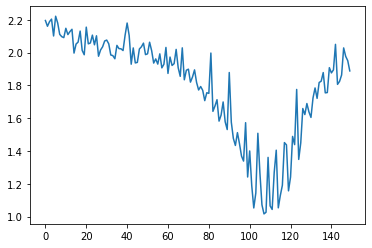

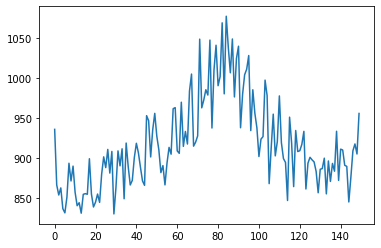

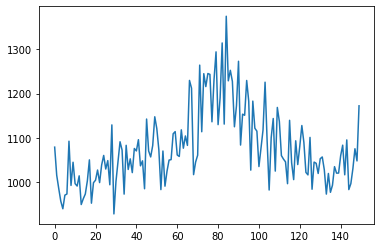

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.plot(stats1)
plt.figure()
plt.plot(stats2)
plt.figure()
plt.plot(stats3)